In [1]:
import time

from dgl.dataloading import GraphDataLoader
import torch

from prob import VRPDGLDataset
from solver import return2Depot
from utils import checkValid, routesPlot

Using backend: pytorch


In [2]:
def run(size, rou_agent_type):
    """
    A function to evaluate different algorithms

    Args:
        size(int): graph size
        algo (str): name of algorithm
        solver_args (tuple): args of solver
    """
    cnt = 0
    # device
    print("Device:")
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    print("  {}".format(device))
    # load test data
    print("\nLoad data...")
    print("  Graph size: {}".format(size))
    data = VRPDGLDataset(size=size, num_samples=1000)
    batch = 1
    dataloader = GraphDataLoader(data, batch_size=batch, shuffle=False)
    # init solver
    solver = return2Depot(size, rou_agent_type)
    # solve
    print("\nEvaluating:")
    for batch_data, batch_graph in dataloader:
        cnt += 1
        # to device
        batch_graph = batch_graph.to(device)
        batch_data["loc"] = batch_data["loc"].to(device)
        batch_data["demand"] = batch_data["demand"].to(device)
        batch_data["depot"] = batch_data["depot"].to(device)
        tick = time.time()
        batch_routes, batch_objs = solver.solve(batch_data, batch_graph)
        tock = time.time()
        for i in range(batch):
            obj = batch_objs[i]
            routes = batch_routes[i]
            depot = batch_data["depot"].cpu().detach().numpy()[i]
            loc = batch_data["loc"].cpu().detach().numpy()[i]
            demand = batch_data["demand"].cpu().detach().numpy()[i]
            # print results
            print("Obj Val: {:.4f}".format(obj))
            print("Routes:")
            for r in routes:
                print("  ", "->".join(map(str, r)))
            print("Time elpased: {:.4f} sec".format((tock - tick) / batch))
            # check valid
            assert checkValid(routes, depot, loc, demand), "Infeasible solution."
            # vis
            routesPlot(routes, depot, loc)
        # stop
        if cnt >= 3:
            break
        print()

Device:
  cuda

Load data...
  Graph size: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 75.62it/s]



Loading routing agent...
  [*] Loading model from ./attention_model/pretrained_vrp/vrp_50\epoch-99.pt

Loading return2depot agent...

Evaluating:
Obj Val: 11.5910
Routes:
   2->3->7->16->20->39
   4->48->21->44->6->40->43->13
   33->29->22->36->45->9
   46->19->10->15->8->1
   32->5->31->49->24->41->27
   37->0->25->12->30
   34->42->23->28->26->35->38->47->18
   17->11->14
Time elpased: 5.2652 sec


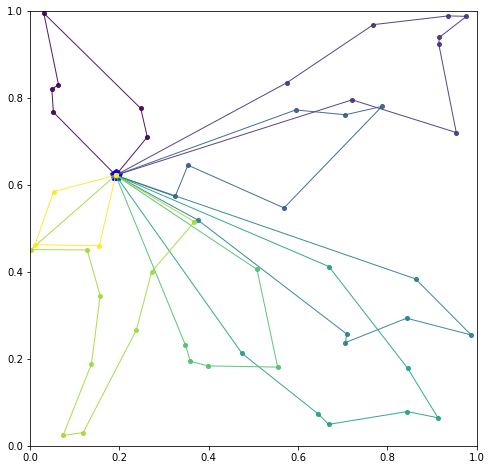


Obj Val: 10.2568
Routes:
   39->28->36->24->20->23->46->47->10
   15->19->42->26->18->8->35->45->22->37
   27->2->41->16->48->21->7->32->14->12
   30->29->44->4->9->5->13
   11->33->49->17->0->38
   6->43->31->1->3
   25->34->40
Time elpased: 1.1208 sec


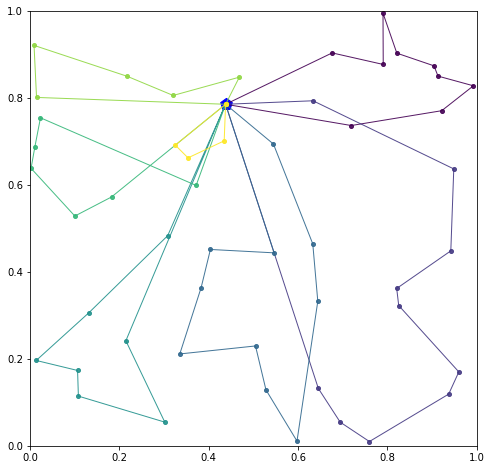


Obj Val: 11.5638
Routes:
   36->24->29->9->48->34
   12->10->26->6->23->22->13->47
   19->41->1->38->15->31->4->43
   2->28->16->8->33->21->42
   30->3->25->49->5->40->17->20
   14->46->32->39->7->27->44->35->11
   0->18->45->37
Time elpased: 1.1597 sec


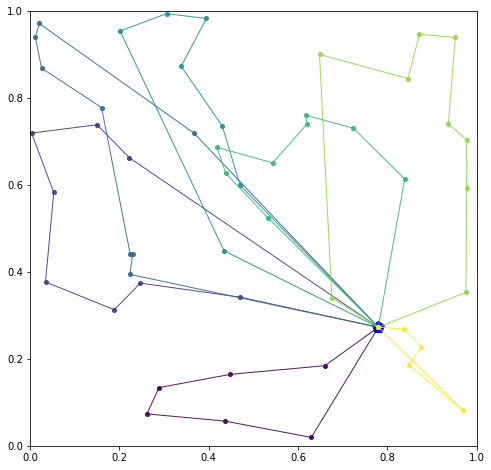

In [3]:
run(size=50, rou_agent_type="vrp")